In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from google.colab import drive
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Training'
test_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Testing'

Text(0.5, 1.0, 'Giloma Tumor')

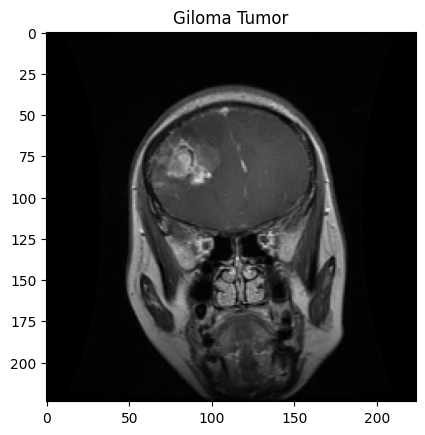

In [4]:
img1_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Training/glioma/Tr-glTr_0000.jpg'
img1 = cv2.resize(cv2.imread(img1_path),(224,224))
plt.imshow(img1, cmap = 'gray')
plt.title('Giloma Tumor')

In [5]:
sub_dir = os.listdir(train_path)

In [6]:
output_dictionary = {}
for i in range(len(sub_dir)):
    output_dictionary.update({sub_dir[i]:i})
output_dictionary

{'notumor': 0, 'glioma': 1, 'pituitary': 2, 'meningioma': 3}

In [7]:
def y_2binary(n):
    z=np.zeros((4), dtype=int)
    z[n]=1
    return z

In [8]:
x_train = []
x_test = []

y_train = []
y_test = []

In [ ]:
# for dir in sub_dir:
#     sub_dir_path = train_path + '/' + dir
#     for img_name in os.listdir(sub_dir_path):
#         img_path = os.path.join(sub_dir_path, img_name)
#         img = cv2.resize(cv2.imread(img_path), (224, 224))

#         x_train.append(img)
#         y_train.append(y_2binary(output_dictionary[dir]))

KeyboardInterrupt: 

In [ ]:
# for dir in sub_dir:
#     sub_dir_path = test_path + '/' + dir
#     for img_name in os.listdir(sub_dir_path):
#         img_path = os.path.join(sub_dir_path, img_name)
#         img = cv2.resize(cv2.imread(img_path), (224, 224))

#         x_test.append(img)
#         y_test.append(y_2binary(output_dictionary[dir]))

In [9]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
# Constants
IMAGE_SIZE = (224, 224)

# Precompute labels for efficiency
def preprocess_labels(sub_dirs, label_dict):
    return {sub_dir: y_2binary(label_dict[sub_dir]) for sub_dir in sub_dirs}

# Process images for a single sub-directory
def process_sub_dir(base_path, dir_name, label):
    x_data, y_data = [], []
    sub_dir_path = Path(base_path) / dir_name

    with os.scandir(sub_dir_path) as entries:
        for entry in entries:
            if entry.is_file():
                img_path = entry.path
                try:
                    img = cv2.resize(cv2.imread(img_path), IMAGE_SIZE)
                    x_data.append(img)
                    y_data.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    return x_data, y_data

# Parallel image processing
def process_images_parallel(base_path, sub_dirs, label_dict):
    x_data, y_data = [], []
    labels = preprocess_labels(sub_dirs, label_dict)

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(process_sub_dir, base_path, dir, labels[dir])
            for dir in sub_dirs
        ]
        for future in futures:
            x, y = future.result()
            x_data.extend(x)
            y_data.extend(y)

    return x_data, y_data

# Process datasets
x_test, y_test = process_images_parallel(test_path, sub_dir, output_dictionary)
x_train, y_train = process_images_parallel(train_path, sub_dir, output_dictionary)

In [10]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# print('The shape of x_train is',x_train.shape,'.')
# print('The shape of x_test is',x_test.shape,'.\n')
# print('The shape of y_train is',y_train.shape,'.')
# print('The shape of y_test is',y_test.shape,'.\n')

The shape of x_train is (5712, 224, 224, 3) .
The shape of x_test is (1311, 224, 224, 3) .

The shape of y_train is (5712, 4) .
The shape of y_test is (1311, 4) .



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Testing/Validation Data Generator (No Augmentation, Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {test_generator.samples}")

Training samples: 5712
Validation samples: 1311


In [13]:
model_temp = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_temp.trainable = False

model = Sequential()
model.add(model_temp)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           2,308 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 941,428 (3.59 MB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [17]:
import time
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    batch_size = 128
)

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=1,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // test_generator.batch_size
# )

# model.save('MobileNetV350epochs64batch_size')
end_time = time.time()

print('The training of the Transfer Learning model took',round((end_time-start_time)/60),'minutes.')

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.2925 - loss: 1.3622 - val_accuracy: 0.3089 - val_loss: 1.3364
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3046 - loss: 1.3405 - val_accuracy: 0.3707 - val_loss: 1.3180
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3807 - loss: 1.3194 - val_accuracy: 0.4195 - val_loss: 1.3071
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4006 - loss: 1.3030 - val_accuracy: 0.4134 - val_loss: 1.2861
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4304 - loss: 1.2887 - val_accuracy: 0.4523 - val_loss: 1.2720
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4395 - loss: 1.2765 - val_accuracy: 0.4950 - val_loss: 1.2587
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4072 - loss: 1.2625 - val_accuracy: 0.4333 - val_loss: 1.2526
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4312 - loss: 1.2569 - val_accuracy: 0.4737 - v

In [18]:
# val_loss, val_accuracy = model.evaluate(x_test, y_test)

test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 785ms/step - accuracy: 0.5868 - loss: 1.1189
Test Loss: 1.1179
Test Accuracy: 57.27%


In [19]:
print(history.history)

{'accuracy': [0.3093487322330475, 0.32475489377975464, 0.37237393856048584, 0.40423670411109924, 0.424369752407074, 0.4415266215801239, 0.4215686321258545, 0.4432772994041443, 0.46078431606292725, 0.47286415100097656, 0.4602591097354889, 0.46376049518585205, 0.46183472871780396, 0.48476889729499817, 0.48161765933036804, 0.4782913029193878, 0.494047611951828, 0.5180321931838989, 0.4961484670639038, 0.5080532431602478, 0.5162814855575562, 0.5302870869636536, 0.5301120281219482, 0.5497198700904846, 0.5346638560295105, 0.5231092572212219, 0.5343137383460999, 0.5273109078407288, 0.5215336084365845, 0.5385153889656067, 0.5376400351524353, 0.5432422757148743, 0.543767511844635, 0.5299369692802429, 0.5525209903717041, 0.5421918630599976, 0.5462185144424438, 0.5446428656578064, 0.5378151535987854, 0.5395658016204834, 0.5346638560295105, 0.529411792755127, 0.5467436909675598, 0.5598739385604858, 0.5469187498092651, 0.5575980544090271, 0.5530462265014648, 0.5495448112487793, 0.536939799785614, 0.

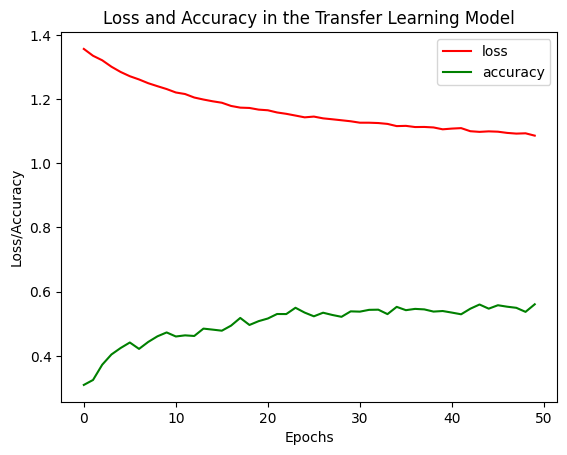

In [20]:
plt.plot(history.history["loss"],c="red")
plt.plot(history.history["accuracy"],c="green")
plt.title("Loss and Accuracy in the Transfer Learning Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend(['loss','accuracy'])
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(model.predict(test_generator),axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [ ]:
# display = ConfusionMatrixDisplay(confusion_matrix(test, predictions))
# display.plot()
# display.ax_.set_title("Confusion matrix for the Transfer Learning model.")
# plt.show()

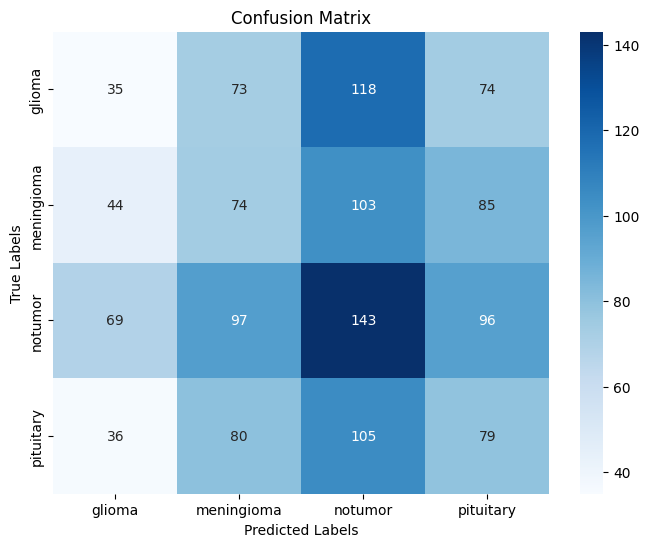

In [22]:
import seaborn as sns

true_labels = test_generator.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
